In [18]:
import pandas as pd
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# --- データ読み込み用関数 (try...except 削除) ---

def get_behaiver_map(filepath: str) -> dict:
    """
    指定されたパスのファイルを読み込み、行動名とIDの辞書を生成する。
    """
    behavior_to_id = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            parts = line.rsplit(maxsplit=1)
            if len(parts) == 2:
                name = parts[0].strip()
                id_val = int(parts[1])
                behavior_to_id[name] = id_val
    return behavior_to_id

def create_dataframe_manually_robust(filepath: str) -> pd.DataFrame:
    """
    ファイルを1行ずつ手動で読み込み、DataFrameを構築する。
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        header_line = f.readline()
        if not header_line:
            # ヘッダーが空なら空のDFを返すが、これはエラーではない
            return pd.DataFrame() 
        
        columns = re.split(r'\s+', header_line.strip())
        num_columns = len(columns)
        data_rows = []
        
        for line_num, line in enumerate(f, 2):
            line_stripped = line.strip()
            if not line_stripped:
                continue
            
            row_data = re.split(r'\s+', line_stripped)
            
            if len(row_data) == num_columns:
                data_rows.append(row_data)
            elif len(row_data) > num_columns:
                order = row_data[-1]
                family = row_data[-2]
                genus = ' '.join(row_data[:-2])
                reconstructed_row = [genus, family, order]
                data_rows.append(reconstructed_row)
            else:
                # 元のコードにあった警告出力 (エラーハンドリングではないため維持)
                print(f"警告: 行 {line_num}: 列数が期待値 ({num_columns}) 未満のためスキップ。内容: '{line_stripped}'", file=sys.stderr)
        
        df = pd.DataFrame(data_rows, columns=columns)
        return df

# --- 動画解析関数 (修正版) ---

def find_and_show_max_diff_frame_with_labels(video_path: str, genus_label: str, action_label: str):
    """
    動画を読み込み、フレーム間差分が最大のフレームをラベル付きでplt.show()表示する。
    """
    
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"エラー: 動画ファイル {video_path} を開けません。", file=sys.stderr)
        return

    max_diff = -1.0
    max_diff_frame = None
    
    ret, prev_frame = cap.read()
    if not ret:
        print("エラー: 動画からフレームを読み込めません。", file=sys.stderr)
        cap.release()
        return

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    max_diff_frame = prev_frame.copy()

    while True:
        ret, current_frame = cap.read()
        if not ret:
            break

        current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        frame_diff = cv2.absdiff(prev_gray, current_gray)
        current_diff = np.sum(frame_diff)

        if current_diff > max_diff:
            max_diff = current_diff
            max_diff_frame = current_frame.copy()

        prev_gray = current_gray

    cap.release()

    if max_diff_frame is not None:
        max_diff_frame_rgb = cv2.cvtColor(max_diff_frame, cv2.COLOR_BGR2RGB)
        
        # タイトルに Genus と ActionLabel を設定
        title = f"Genus: {genus_label} | Action: {action_label}\n(Frame with Max Diff: {max_diff:.0f})"

        plt.figure(figsize=(10, 7))
        plt.imshow(max_diff_frame_rgb)
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print("最大差分フレームを特定できませんでした。", file=sys.stderr)


--- サンプル対象 ---
Path (Full): /mnt/nfs/mammal_net/trimmed_videos/LHPx7AiTQeY.mp4
Genus: cephalophinae
Action: hunts_other_animals
--------------------


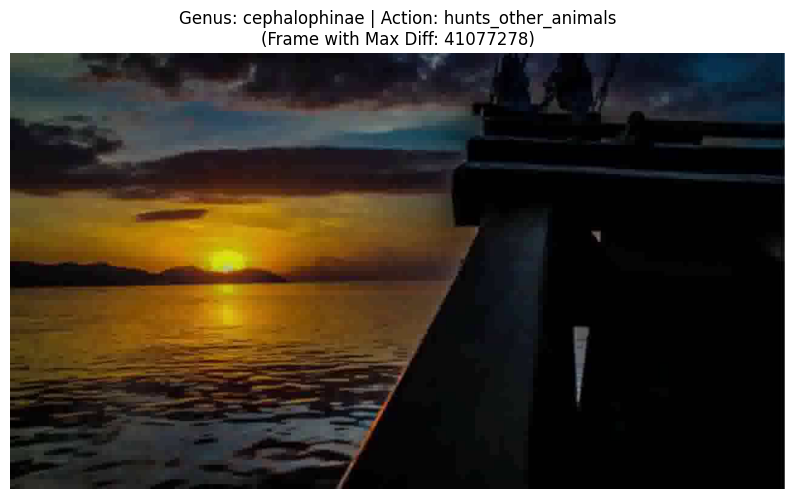

In [30]:
# ファイルパス定義
data_base_dir = '/mnt/nfs/mammal_net/' # 動画パスのプレフィックスとしても使用
train_csv_path = os.path.join(data_base_dir, 'annotation/composition/train.csv')
behavior_map_path = os.path.join(data_base_dir, 'annotation/behavior_to_id.txt')
taxonomy_path = os.path.join(data_base_dir, 'annotation/taxonomy.txt')

# train_df (FileNotFoundError のハンドリングを削除)
train_df = pd.read_csv(train_csv_path, header=None, names=['video_path', 'action_label', 'mammal_category'], sep=' ')

# behavior_dict (FileNotFoundError のハンドリングを削除)
inv_behavior_dict = get_behaiver_map(behavior_map_path)
behavior_dict = {v: k for k, v in inv_behavior_dict.items()}
if not behavior_dict:
    print(f"警告: {behavior_map_path} から行動辞書を作成できませんでした。", file=sys.stderr)

# mammal_category_df (FileNotFoundError のハンドリングを削除)
mammal_category_df = create_dataframe_manually_robust(taxonomy_path)
if mammal_category_df.empty:
    print(f"警告: {taxonomy_path} から分類辞書を作成できませんでした。", file=sys.stderr)
else:
    mammal_category_df = mammal_category_df.reset_index()
    mammal_category_df = mammal_category_df.rename(columns={'index': 'mammal_category'})

# マージ
train_df['action_label_name'] = train_df['action_label'].map(behavior_dict)
if not mammal_category_df.empty:
    train_df = train_df.merge(on='mammal_category', right=mammal_category_df, how='left', suffixes=('', '_y'))
else:
    print("分類DFが空のため、マージをスキップします。", file=sys.stderr)

# フィルタリング
if 'Order' in train_df.columns and 'Family' in train_df.columns:
    target_orders = ['aerissodactyla', 'artiodactyla']
    target_families = ['bovidae', 'cervidae']
    train_df = train_df.loc[train_df['Order'].isin(target_orders)]
    train_df = train_df.loc[train_df['Family'].isin(target_families)]
else:
    print("警告: 'Order' または 'Family' 列が存在しないため、フィルタリングをスキップします。", file=sys.stderr)


# --- 2. サンプリングと動画解析の実行 ---

# DataFrameからランダムに1行サンプリング (例外ハンドリングを削除)
sampled_row = train_df.sample(n=1).iloc[0]

# メタデータを抽出
video_path_relative = sampled_row['video_path']
genus = sampled_row['Genus']
action = sampled_row['action_label_name']

# 動画パスを構築
full_video_path = os.path.join(data_base_dir, video_path_relative)

print(f"\n--- サンプル対象 ---")
print(f"Path (Full): {full_video_path}")
print(f"Genus: {genus}")
print(f"Action: {action}")
print("--------------------")

# 修正版の関数を実行
find_and_show_max_diff_frame_with_labels(full_video_path, genus, action)